In [ ]:
# Per treballar amb COCO necessitam instal·lar aquesta llibreria.
# Cada cop que iniciam l'entorn s'ha d'executar

!pip install pycocotools

# Pràctica 2: UNET
Lluís Camino Pérez

## Introducció
En aquesta pràctica, s'exposa el procediment duit a terme per a entrenar un
model capaç de realitzar segmentació semàntica a fotografies. El model que s'ha
implementat es el UNET, i s'ha emprat el *dataset* de [COCO](https://cocodataset.org#home).

## Cárrega de dades

En primer lloc hem de carregar les dades necessàries. Com hem comentat a l'enunciat farem feina amb la versió 2014 de [COCO](https://cocodataset.org#home)

In [ ]:
import math
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.transform import resize

import tensorflow as tf

from pycocotools.coco import COCO
import pycocotools.mask as maskUtils

A continuació, conectact el _notebook_ amb la carpeta `unet_aa` de Drive i carregam la classe `MyGeneration`, que ens permetrà carregar les dades de COCO.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/My Drive/unet_aa

Mounted at /content/gdrive
/content/gdrive/My Drive/unet_aa


In [ ]:
class MyGeneration(tf.keras.utils.Sequence):
  
  def __init__(self, category, batch_size, train=True):

    dataDir = ''
    dataType = 'val2014'
    annFile = '{}annotations/instances_{}.json'.format(dataDir,dataType)

    self.coco = COCO(annFile)
    
    self.batch_size = batch_size
    self.cat = category
    self.catIds = self.coco.getCatIds(catNms=['dog']);
    self.imgIds = self.coco.getImgIds(catIds=self.catIds);
    
    if train:
      self.imgIds = self.imgIds[:int(len(self.imgIds)*0.75)]
    else: 
      self.imgIds = self.imgIds[int(len(self.imgIds)*0.75):]
  
  def __len__(self):  
    return math.ceil(len(self.imgIds) / self.batch_size)
    
  def __getitem__(self, idx):
    
    batch_x = self.coco.loadImgs(self.imgIds[idx * self.batch_size:(idx + 1) * self.batch_size])
    
    self.annIds = self.coco.getAnnIds(imgIds=self.imgIds[idx * self.batch_size:(idx + 1) * self.batch_size],
                                 catIds=self.catIds, iscrowd=False)
    
    pre_batch_y = []

    for img_id in self.imgIds[idx * self.batch_size:(idx + 1) * self.batch_size]:

      annIds      = self.coco.getAnnIds(imgIds=img_id, catIds=self.catIds, iscrowd=False)
      annotations = self.coco.loadAnns(annIds)
      mask        = self.coco.annToMask(annotations[0])
      
      for ann in annotations[1:]:
        mask += self.coco.annToMask(ann)
      mask = resize(mask, (256, 256, 1))
      mask[mask>0] = 1

      pre_batch_y.append(mask)


    return (np.array([resize(imread(file_name['coco_url']), (256, 256, 3)) for file_name in batch_x]), 
            np.array([mask for mask in pre_batch_y]))

Finalment només ens queda crear els dos generadors i obtenir els conjunt d'entrenament i de prova.

In [ ]:
gen_train = MyGeneration('dog', 370)
gen_test = MyGeneration('dog', 370, False)

In [ ]:
test_x = [x[0] for x in gen_test]
test_y = [x[1] for x in gen_test]
train_x = [x[0] for x in gen_train]
train_y = [x[1] for x in gen_train]

### Importar les llibreries

In [ ]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras

## Definició del model

A continuació, es troba la implementació de la xarxa neuronal UNET. S'ha creat la segona part del model, i s'han afegit capes `Dropout` per millorar el rendiment de la xarxa.


In [ ]:
def unet(input_size = (256, 256, 3), output_channels = 1):
    dilation_rate = 1 # No modificar
    inputs = Input(input_size)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(inputs)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(conv1)
    pool1 = Dropout(0.5)(pool1)

    conv2 = Conv2D(32, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(pool1)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(64, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(pool2)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv3) 
    pool3 = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(128, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(pool3) 
    conv4 = Conv2D(128, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(conv4)
    pool4 = Dropout(0.5)(pool4)

    conv5 = Conv2D(256, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(pool4)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv5)  
    
    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=3)
    conv6 = Dropout(0.5)(up6)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(up6)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv6)  
    
    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=3)
    conv7 = Dropout(0.5)(up7)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(up7)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv7)  
    
    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=3)
    conv8 = Dropout(0.5)(up8)
    conv8 = Conv2D(32, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(up8)
    conv8 = Conv2D(32, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv8)  

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=3)
    conv9 = Dropout(0.5)(up9)
    conv9 = Conv2D(16, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(up9)
    conv9 = Conv2D(16, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv9)

    output = Conv2D(1, (1,1), padding="same", activation="sigmoid")(conv9)

    model = tf.keras.Model(inputs, output)
    
    return model

El que farem ara, es en primer lloc, generar un esquema del model. Després, el
compilarem i entrenarem.

In [ ]:
model = unet()
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)
# TODO: compilar
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

# TODO: Entrenar
model.fit(train_x[0], train_y[0], validation_data=(test_x[0], test_y[0]), epochs=2)

Epoch 1/2
12/12 [==============================] - 327s 27s/step - loss: 0.8996 - accuracy: 0.8298 - val_loss: 0.6177 - val_accuracy: 0.9123
Epoch 2/2
12/12 [==============================] - 325s 27s/step - loss: 0.4079 - accuracy: 0.9072 - val_loss: 0.3541 - val_accuracy: 0.9123


## Avaluació

A continuació, es mostren els resultats d'aplicar la xarxa neuronal que acabam
d'entrenar sobre algunes imatges del conjunt de test.

In [ ]:
# Obtenim el primer batch del conjunt d' avaluació
gen_test2 = MyGeneration('dog', 10, False)
test_x2 = [x[0] for x in gen_test2]
with open('test_x2.npy', 'wb') as f:
    np.save(f, np.array(test_x2))
#test_x2 = np.load('test_x2.npy', allow_pickle=True)

loading annotations into memory...
Done (t=11.74s)
creating index...
index created!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """


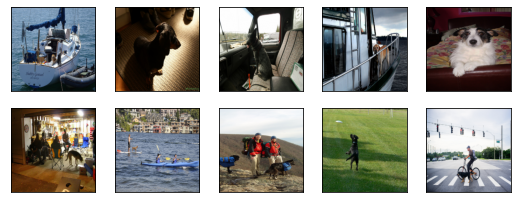

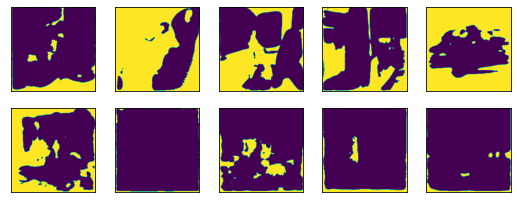

In [ ]:
def show_results(test):
  # Realitzam la predicció
  prediccio = model.predict(test)

  # Mostram els resultats
  n_images = len(prediccio)

  figure = plt.figure(1, figsize=(9, 9))

  for i in range(n_images):

    ax = plt.subplot(n_images/2, n_images//2, i + 1)
    ax.imshow(test[i,:,:,:])
    ax.set_xticks(())
    ax.set_yticks(())

  figure = plt.figure(2, figsize=(9, 9))

  j = 0.25
  for i in range(n_images):

    ax = plt.subplot(n_images/2, n_images//2, i + 1)
    predit = prediccio[i][:,:,0]
    predit[predit > j] = 255
    predit[predit < 255] = 0 
    predit = predit.astype(np.uint8)
    ax.imshow(predit)
    ax.set_xticks(())
    ax.set_yticks(())

show_results(test_x2[0])

## Referències
* [Towards Data Science, UNet — Line by Line Explanation](https://towardsdatascience.com/unet-line-by-line-explanation-9b191c76baf5)